In [30]:
from google.colab import drive
import os
import sys
import shutil
import subprocess

drive.mount('/content/drive')

# Project paths
PROJECT_PATH = '/content/drive/MyDrive/SVGEditor'
CODE_PATH = f"{PROJECT_PATH}/code"
MODEL_PATH = f"{PROJECT_PATH}/models/qwen-image-edit"
OUTPUT_PATH = f"{PROJECT_PATH}/output"

if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Target configuration
TARGET_NAME = "153_B"
TARGET_OUTPUT_PATH = f"{OUTPUT_PATH}/{TARGET_NAME}"

# Input image path (from project resource folder)
INPUT_IMAGE = f"{CODE_PATH}/resource/{TARGET_NAME}.png"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install dependencies
%pip install diffusers accelerate safetensors transformers huggingface_hub segment-anything opencv-python pillow matplotlib scikit-image scikit-learn cairosvg moviepy shapely networkx lxml skan rdp

import shutil
import subprocess

# Clean and clone repository
if os.path.exists(CODE_PATH):
    shutil.rmtree(CODE_PATH)

os.chdir(PROJECT_PATH)
result = subprocess.run(['git', 'clone', 'https://github.com/huanbasara/SVGEditor.git', 'code'],
                       capture_output=True, text=True)
print(f"Repository {'successfully' if result.returncode == 0 else 'failed'} cloned")

# Display latest commit info
os.chdir(CODE_PATH)
commit_info = subprocess.run(['git', 'log', '-1', '--pretty=format:%ci|%s'],
                           capture_output=True, text=True)

if commit_info.returncode == 0:
    commit_time, commit_msg = commit_info.stdout.strip().split('|', 1)
    print(f"Latest commit: {commit_time.split()[0]} - {commit_msg}")

# Add to Python path and reload modules
if CODE_PATH not in sys.path:
    sys.path.insert(0, CODE_PATH)

# Clear custom modules from cache
for base in ['sam_processor', 'svglib', 'utils']:
    to_remove = [m for m in sys.modules if m.startswith(base)]
    for m in to_remove:
        del sys.modules[m]

# Create necessary directories
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(TARGET_OUTPUT_PATH, exist_ok=True)

print("Setup complete!")

Repository successfully cloned
Latest commit: 2025-10-03 - finish the diffusion part of workflow
Setup complete!


Clearing GPU memory...
Loading model...


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/9 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✅ Model loaded with CPU offload
Edit prompt: Transform this girl's long ponytail into a chic, shoulder-length layered cut. Remove all long flowing hair. Ensure clean, continuous lines without artifacts. Maintain the exact same minimalist black line art style on pure white background. Convert all lines to uniform deep black color with consistent thickness. Keep all unmodified parts with their original line structure, position, and curvature. Ensure all lines are clear, smooth, and of the same color depth and weight. Avoid any variations in line weight or opacity within the new image.
Negative prompt: inconsistent line thickness, varying line weight, gradient lines, non-uniform line opacity, thick and thin lines mixed, uneven line density, color variations in lines, non-black lines, colored lines, gradient effects, white background noise, speckles, dots, artifacts, jagged edges, broken lines, discontinuous lines, blurry lines, low quality, distorted, messy


  0%|          | 0/30 [00:00<?, ?it/s]

Edited image saved: /content/drive/MyDrive/SVGEditor/output/153_B/1.153_B_qwen_edit.png


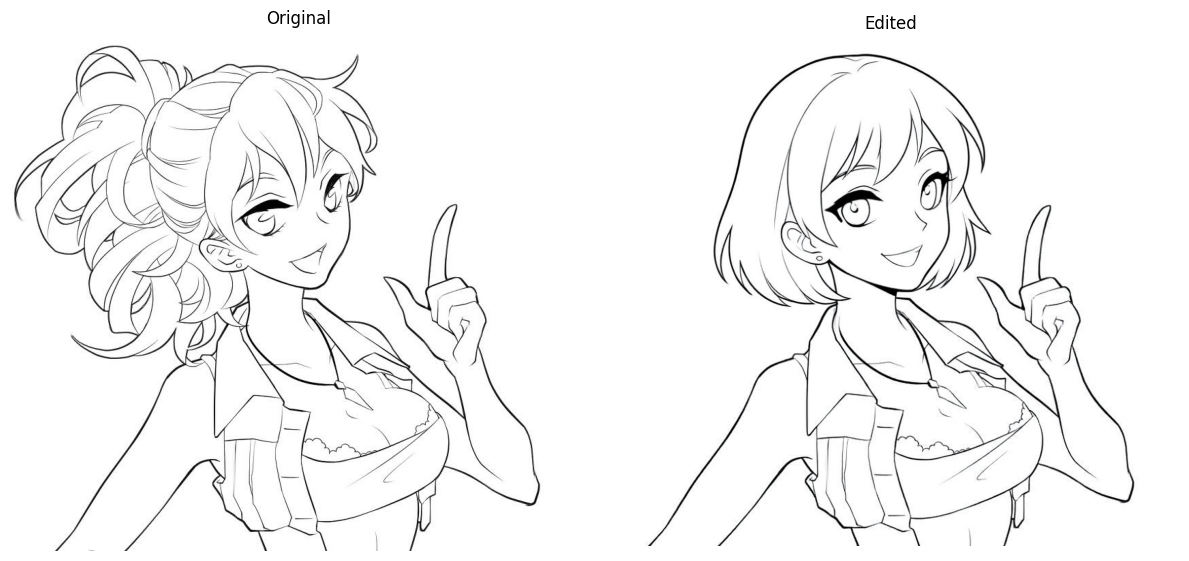

In [ ]:
# Image Editing with Qwen

import torch
import gc
from PIL import Image
from diffusers import QwenImageEditPipeline
from utils.prompt_utils import get_prompt, get_negative_prompt
from utils.plot_utils import plot_images

def load_qwen_model():
    """Load Qwen image editing model"""
    print("Clearing GPU memory...")
    torch.cuda.empty_cache()
    gc.collect()

    print("Loading model...")
    pipeline = QwenImageEditPipeline.from_pretrained(
        MODEL_PATH,
        local_files_only=True,
        torch_dtype=torch.bfloat16
    )
    pipeline.set_progress_bar_config(disable=None)
    pipeline.enable_model_cpu_offload()
    print("✅ Model loaded with CPU offload")
    return pipeline

def process_image_with_qwen(pipeline, image, prompt, negative_prompt):
    """Process image with Qwen model"""
    inputs = {
        "image": image,
        "prompt": prompt,
        "generator": torch.manual_seed(0),
        "true_cfg_scale": 4.0,
        "negative_prompt": negative_prompt,
        "num_inference_steps": 30,
    }

    with torch.inference_mode():
        output = pipeline(**inputs)
        output_image = output.images[0]

    # Save edited image
    output_path = f"{TARGET_OUTPUT_PATH}/{TARGET_NAME}_qwen_edit.png"
    output_image.save(output_path)
    print(f"Edited image saved: {output_path}")

    return output_image

# Execute image editing
pipeline = load_qwen_model()
original_image = Image.open(INPUT_IMAGE)
edit_prompt = get_prompt(TARGET_NAME)
negative_prompt = get_negative_prompt()
print(f"Edit prompt: {edit_prompt}")
print(f"Negative prompt: {negative_prompt}")

edited_image = process_image_with_qwen(pipeline, original_image, edit_prompt, negative_prompt)

plot_images([(original_image, "Original"), (edited_image, "Edited")])

In [ ]:
# Cleanup
del pipeline
torch.cuda.empty_cache()
gc.collect()
print("Processing completed")

Processing completed


=== Fill-to-Outline Processing ===
Loading image: /content/drive/MyDrive/SVGEditor/output/153_B/153_B_qwen_edit.png
Original image shape: (960, 1088)
Binary threshold: 180
White pixels: 47516
Processed 9 thick filled regions
Binary image saved: /content/drive/MyDrive/SVGEditor/output/153_B/153_B_binary.png
Outline image saved: /content/drive/MyDrive/SVGEditor/output/153_B/153_B_outline.png
✅ Fill-to-outline processing completed!


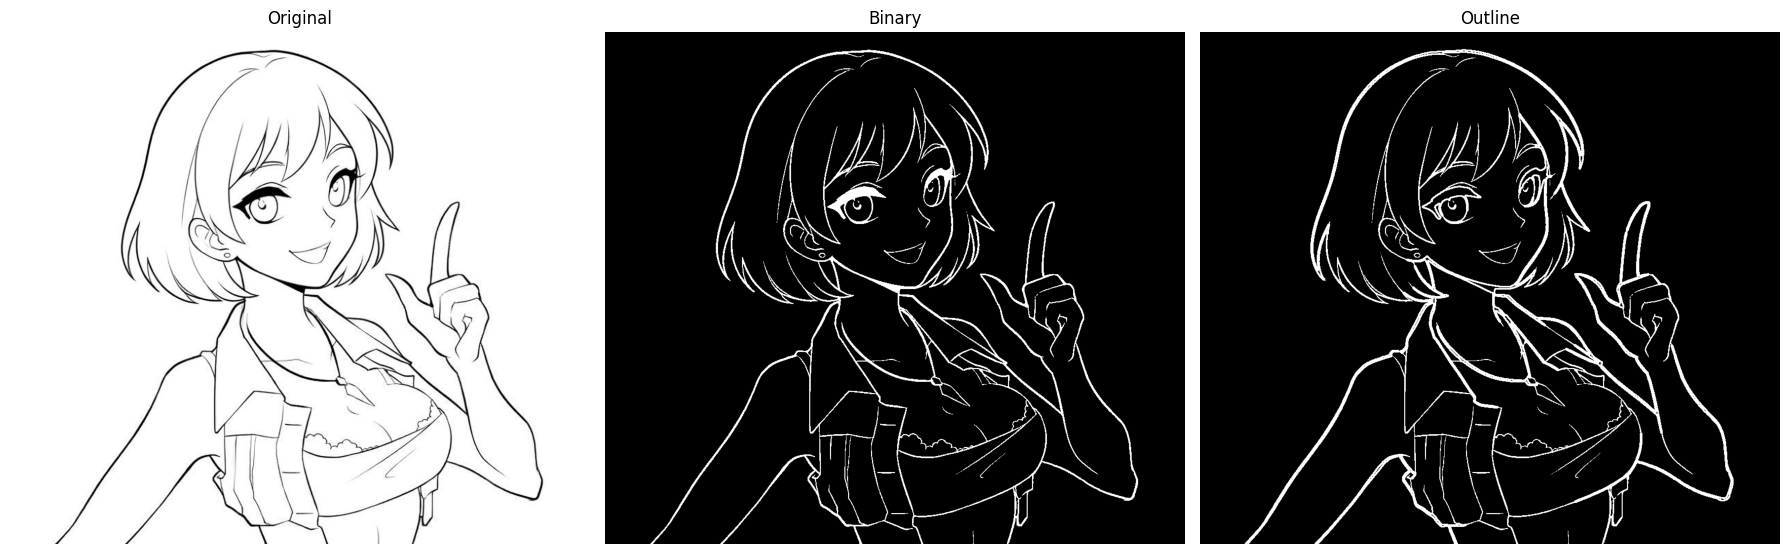

In [33]:
# Fill-to-Outline Processing

import cv2
import numpy as np
from PIL import Image
import os
from utils.plot_utils import plot_images

# Processing parameters
BINARY_THRESHOLD = 180
THICKNESS_THRESHOLD = 3  # Higher threshold to detect truly thick fills
MIN_FILL_AREA = 500  # Minimum area for filled regions
OUTLINE_WIDTH = 2

def convert_fills_to_outlines(binary_img):
    """
    Convert thick filled regions to outline borders using local detection.

    Key improvement: Process only locally thick regions, not entire connected components.
    This prevents thin lines connected to thick fills from being removed.
    """
    # Step 1: Detect thick regions using morphological erosion
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (THICKNESS_THRESHOLD, THICKNESS_THRESHOLD))
    eroded = cv2.erode(binary_img, kernel)

    # Step 2: Find connected components in the eroded image (only truly thick fills survive)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(eroded)

    result_img = binary_img.copy()
    processed_count = 0

    for i in range(1, num_labels):
        area = stats[i, cv2.CC_STAT_AREA]

        # Only process large filled regions
        if area < MIN_FILL_AREA:
            continue

        # Step 3: Get the component mask from eroded image
        component_mask = (labels == i).astype(np.uint8) * 255

        # Step 4: Dilate back to recover the original fill boundary
        dilated_mask = cv2.dilate(component_mask, kernel)

        # Step 5: Extract this region from original binary image
        original_fill = cv2.bitwise_and(binary_img, dilated_mask)

        # Step 6: Create outline from this fill
        outline_mask = create_outline_from_fill(original_fill)

        # Step 7: Remove the fill and add outline (only in this local region)
        result_img = cv2.bitwise_and(result_img, cv2.bitwise_not(dilated_mask))
        result_img = cv2.bitwise_or(result_img, outline_mask)
        processed_count += 1

    print(f"Processed {processed_count} thick filled regions")
    return result_img

def binarize_image(img):
    """Binarize image (inverted: white lines on black background)"""
    _, binary = cv2.threshold(img, BINARY_THRESHOLD, 255, cv2.THRESH_BINARY_INV)
    print(f"Binary threshold: {BINARY_THRESHOLD}")
    print(f"White pixels: {np.sum(binary > 0)}")
    return binary

def create_outline_from_fill(fill_mask):
    """Generate outline from fill region"""
    contours, _ = cv2.findContours(fill_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    outline_mask = np.zeros_like(fill_mask)

    for contour in contours:
        cv2.drawContours(outline_mask, [contour], -1, 255, thickness=OUTLINE_WIDTH)

    return outline_mask

def process_fill_to_outline():
    """Process fill-to-outline conversion"""
    input_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_qwen_edit.png")

    if not os.path.exists(input_path):
        print(f"ERROR: Input file not found: {input_path}")
        return None

    print(f"Loading image: {input_path}")
    img = cv2.imread(input_path, cv2.IMREAD_GRAYSCALE)
    print(f"Original image shape: {img.shape}")

    # Binarize
    binary = binarize_image(img)

    # Convert fills to outlines
    outline_img = convert_fills_to_outlines(binary)

    # Save results
    binary_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_binary.png")
    outline_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_outline.png")

    cv2.imwrite(binary_path, binary)
    cv2.imwrite(outline_path, outline_img)

    print(f"Binary image saved: {binary_path}")
    print(f"Outline image saved: {outline_path}")

    return binary, outline_img

# Execute fill-to-outline processing
print("=== Fill-to-Outline Processing ===")
binary_result, outline_result = process_fill_to_outline()

if outline_result is not None:
    print("✅ Fill-to-outline processing completed!")

    # Load images for visualization
    original_path = os.path.join(TARGET_OUTPUT_PATH, f"{TARGET_NAME}_qwen_edit.png")

    original_img = cv2.imread(original_path, cv2.IMREAD_GRAYSCALE)

    if original_img is not None:
        # Convert to PIL for plot_images
        original_pil = Image.fromarray(original_img).convert('RGB')
        binary_pil = Image.fromarray(binary_result).convert('RGB')
        outline_pil = Image.fromarray(outline_result).convert('RGB')

        plot_images([
            (original_pil, "Original"),
            (binary_pil, "Binary"),
            (outline_pil, "Outline")
        ])
    else:
        print("❌ Cannot load images for visualization")
else:
    print("❌ Fill-to-outline processing failed!")